In [2]:
# U.S. States Population Data Scraper
# Import required libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


# URL of the Wikipedia page with U.S. states population data
URL = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population"

def fetch_wikipedia_page(url):
    """Fetch the Wikipedia page content."""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.text

def parse_population_data(html_content):
    """Parse the HTML content to extract population data."""
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    if not table:
        raise ValueError("Could not find the population data table on the page")
    return pd.read_html(str(table))[0]

def clean_data(df):
    """Clean and process the population data."""
    df_clean = df.copy()
    df_clean = df_clean.dropna(how='all')
    df_clean.columns = [col.strip() for col in df_clean.columns]
    state_col = df_clean.columns[1]
    df_clean[state_col] = df_clean[state_col].str.replace(r'\[.*?\]', '', regex=True).str.strip()
    pop_col = df_clean.columns[2]
    df_clean[pop_col] = df_clean[pop_col].astype(str).str.replace(r'[^\d]', '', regex=True).astype('int64')
    return df_clean

# Main execution
print("Fetching U.S. states population data from Wikipedia...")
try:
    # Fetch and process the data
    html_content = fetch_wikipedia_page(URL)
    df = parse_population_data(html_content)
    df_clean = clean_data(df)
    
    # Display first 10 rows
    print("\nFirst 10 rows of the scraped data:")
    display(df_clean.head(10))
    
    # Save to CSV with the required filename
    csv_filename = 'CSC221-webscrape-data.csv'
    df_clean.to_csv(csv_filename, index=False)
    print(f"\nData successfully saved to {csv_filename}")
    
except Exception as e:
    print(f"An error occurred: {e}")

Fetching U.S. states population data from Wikipedia...

First 10 rows of the scraped data:


C:\Users\trist\AppData\Local\Temp\ipykernel_47344\1405848268.py:27: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  return pd.read_html(str(table))[0]


,State/federal district/territory/ division/region,#,2020 pop.,#.1,2010 pop.,#.2,2000 pop.,#.3,2010– 2020 change,Geo. sort
0,Massachusetts,15,7029917,14,6547629,13,6349097,21,7.4%,NEng
1,Connecticut,29,3605944,29,3574097,29,3405565,47,0.9%,NEng
2,New Hampshire,41,1377529,42,1316470,41,1235786,30,4.6%,NEng
3,Maine,42,1362359,41,1328361,40,1274923,42,2.6%,NEng
4,Rhode Island,43,1097379,43,1052567,43,1048319,31,4.3%,NEng
5,Vermont,49,643077,49,625741,49,608827,40,2.8%,NEng
6,New England,9,15116205,9,14444865,9,13922517,7,4.6%,NEast
7,New York,4,20201249,3,19378102,3,18976457,32,4.2%,MAtl
8,Pennsylvania,5,13002700,6,12702379,6,12281054,43,2.4%,MAtl
9,New Jersey,11,9288994,11,8791894,9,8414350,25,5.7%,MAtl



Data successfully saved to CSC221-webscrape-data.csv


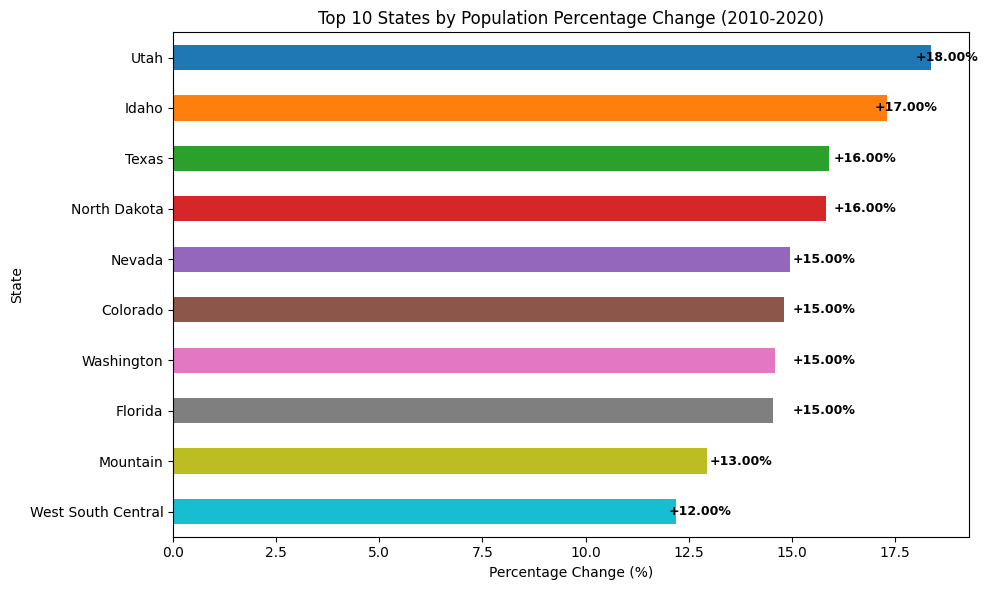

Top states and percentage changes:
Utah: +18.00%
Idaho: +17.00%
Texas: +16.00%
North Dakota: +16.00%
Nevada: +15.00%
Colorado: +15.00%
Washington: +15.00%
Florida: +15.00%
Mountain: +13.00%
West South Central: +12.00%


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Robustly detect relevant columns
possible_state_cols = [c for c in df_clean.columns if 'State' in c or 'state' in c or 'federal' in c]
if possible_state_cols:
    state_col = possible_state_cols[0]
else:
    state_col = df_clean.columns[1]

possible_2020 = [c for c in df_clean.columns if '2020' in c]
possible_2010 = [c for c in df_clean.columns if '2010' in c]

if possible_2020:
    pop_2020_col = possible_2020[0]
else:
    pop_2020_col = df_clean.columns[2]

if possible_2010:
    pop_2010_col = possible_2010[0]
else:
    # fallback to the column after the 2020 column
    idx = list(df_clean.columns).index(pop_2020_col)
    pop_2010_col = df_clean.columns[idx + 1] if idx + 1 < len(df_clean.columns) else df_clean.columns[3]

# Prepare dataframe and ensure numeric types
df_tmp = df_clean.copy()
df_tmp[pop_2020_col] = pd.to_numeric(df_tmp[pop_2020_col], errors='coerce')
df_tmp[pop_2010_col] = pd.to_numeric(df_tmp[pop_2010_col], errors='coerce')
df_tmp = df_tmp.dropna(subset=[pop_2020_col, pop_2010_col])

# Calculate percentage change
df_tmp['pct_change'] = (df_tmp[pop_2020_col] - df_tmp[pop_2010_col]) / df_tmp[pop_2010_col] * 100

# Select top 10 states by percentage change
# Filter to likely state rows by rank column if available
rank_candidates = [c for c in df_tmp.columns if c.strip() == '#' or 'rank' in c.lower()]
if rank_candidates:
    rank_col = rank_candidates[0]
    df_tmp[rank_col] = pd.to_numeric(df_tmp[rank_col], errors='coerce')
    df_states = df_tmp[(df_tmp[rank_col] > 0) & (df_tmp[rank_col] <= 50)].copy()
else:
    # fallback: keep rows where state name is not aggregate keywords
    df_states = df_tmp[~df_tmp[state_col].str.contains('Total|region|Island|Territories|states', case=False, na=False)].copy()

top_n = 10
top = (
    df_states.sort_values('pct_change', ascending=False)
    .head(top_n)
    .set_index(state_col)['pct_change']
)

# Format to two significant figures for display but keep numeric for plotting
from math import log10, floor

def to_2_sig(x):
    if x == 0:
        return 0.0
    return round(x, -int(floor(log10(abs(x)))) + 1)

top_display = top.apply(lambda x: to_2_sig(x))

# Plot horizontal bar chart
ax = top.plot(kind='barh', figsize=(10, 6), color=plt.cm.tab10(np.linspace(0, 1, len(top))))
ax.invert_yaxis()
ax.set_xlabel('Percentage Change (%)')
ax.set_ylabel('State')
ax.set_title(f'Top {top_n} States by Population Percentage Change (2010-2020)')

# Annotate bars with percentage values formatted to 2 significant figures
for i, (state, val) in enumerate(top_display.items()):
    ax.text(val + (0.01 * np.sign(val) if val != 0 else 0.01), i, f'{val:+.2f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print('Top states and percentage changes:')
for state, val in top_display.items():
    print(f"{state}: {val:+.2f}%")
